# Capstone: West Nile Virus

![chicago](../datasets/images/chiskyline.png)

reference: [Kaggle Challenge 2015](https://www.kaggle.com/c/predict-west-nile-virus)

- West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death.
- By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today.
- Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.
- Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus.

# Import packages and define functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 

%matplotlib inline 

sns.set_style('ticks', rc={'xtick.direction':'in', 'ytick.direction':'in', \
                           'xtick.top':True, 'ytick.right':True})

# Data Collection and Wrangling

In [2]:
datadir = '../datasets'
datadir_pr = '../datasets/processed'  # directory where the cleaned datasets are stored

## Datasets consist of Main, Spray, Weather, Map data:
- Main Data
    - test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 
- Spray Data
    - spraying to kill mosquitos.
    - the GIS data for their spray efforts in 2011 and 2013.
    - Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 
- Weather Data
    - It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.
    - dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
- Map Data
    - primarily provided for use in visualizations

### Load and check (\& clean) Main dataset

- Train and Test datasets:
    - Trainning sets: consists of data from 2007, 2009, 2011, and 2013
    - Test sets: predict the test results for 2008, 2010, 2012, and 2014

In [3]:
''' Read the training dataset '''
train = pd.read_csv(os.path.join(datadir, 'train.csv'), parse_dates=['Date'], index_col='Date')

In [4]:
train.head()

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10506 entries, 2007-05-29 to 2013-09-26
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Address                 10506 non-null  object 
 1   Species                 10506 non-null  object 
 2   Block                   10506 non-null  int64  
 3   Street                  10506 non-null  object 
 4   Trap                    10506 non-null  object 
 5   AddressNumberAndStreet  10506 non-null  object 
 6   Latitude                10506 non-null  float64
 7   Longitude               10506 non-null  float64
 8   AddressAccuracy         10506 non-null  int64  
 9   NumMosquitos            10506 non-null  int64  
 10  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 984.9+ KB


In [6]:
''' check the missing values '''
train.isnull().sum()
#train.isnull().values.any()

Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

> There is no NaN (null) values in the training datasets

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Block,10506.0,35.687797,24.339468,10.000000,12.000000,33.000000,52.000000,98.000000
Latitude,10506.0,41.841139,0.112742,41.644612,41.732984,41.846283,41.954690,42.017430
Longitude,10506.0,-87.699908,0.096514,-87.930995,-87.760070,-87.694991,-87.627796,-87.531635
AddressAccuracy,10506.0,7.819532,1.452921,3.000000,8.000000,8.000000,9.000000,9.000000
NumMosquitos,10506.0,12.853512,16.133816,1.000000,2.000000,5.000000,17.000000,50.000000
WnvPresent,10506.0,0.052446,0.222936,0.000000,0.000000,0.000000,0.000000,1.000000


In [8]:
''' Check if the dataset is imbalanced '''
# WnvPresent: 0 - negative, 1 - positive
train.WnvPresent.value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

<div class='alert alert-warning'> Note:

- 5% of the training data is tested positive for the virus
- highly imbalanced problem
 
</div>

In [9]:
''' check the species of the trapped mosquitos '''
train.Species.value_counts(sort=True)

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [10]:
''' read the test dataset '''
test = pd.read_csv(os.path.join(datadir, 'test.csv'), parse_dates=['Date'], index_col='Date')

In [11]:
test.head()

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,4,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,5,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116293 entries, 2008-06-11 to 2014-10-02
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Id                      116293 non-null  int64  
 1   Address                 116293 non-null  object 
 2   Species                 116293 non-null  object 
 3   Block                   116293 non-null  int64  
 4   Street                  116293 non-null  object 
 5   Trap                    116293 non-null  object 
 6   AddressNumberAndStreet  116293 non-null  object 
 7   Latitude                116293 non-null  float64
 8   Longitude               116293 non-null  float64
 9   AddressAccuracy         116293 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 9.8+ MB


In [13]:
''' check the missing values '''
test.isnull().sum()
#test.isnull().values.any()

Id                        0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64

> There is no NaN (null) values in the test datasets

In [14]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,116293.0,58147.000000,33571.041765,1.000000,29074.000000,58147.000000,87220.000000,116293.000000
Block,116293.0,41.131100,24.864726,10.000000,18.000000,39.000000,61.000000,98.000000
Latitude,116293.0,41.849389,0.106593,41.644612,41.753411,41.862292,41.951866,42.017430
Longitude,116293.0,-87.693658,0.080699,-87.930995,-87.750938,-87.694991,-87.648860,-87.531635
AddressAccuracy,116293.0,7.954357,1.252733,3.000000,8.000000,8.000000,9.000000,9.000000


### Load and check (& clean) Weather dataset
- the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 
    - Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level 
    - Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [15]:
''' read the weather dataset '''
weather = pd.read_csv(os.path.join(datadir, 'weather.csv'), parse_dates=['Date'], index_col='Date')

In [16]:
weather.head()

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52,M,42,47,13,0,-,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56,2,40,48,9,0,0446,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


In [17]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Tmax         2944 non-null   int64  
 2   Tmin         2944 non-null   int64  
 3   Tavg         2944 non-null   object 
 4   Depart       2944 non-null   object 
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2944 non-null   object 
 7   Heat         2944 non-null   object 
 8   Cool         2944 non-null   object 
 9   Sunrise      2944 non-null   object 
 10  Sunset       2944 non-null   object 
 11  CodeSum      2944 non-null   object 
 12  Depth        2944 non-null   object 
 13  Water1       2944 non-null   object 
 14  SnowFall     2944 non-null   object 
 15  PrecipTotal  2944 non-null   object 
 16  StnPressure  2944 non-null   object 
 17  SeaLevel     2944 non-null   object 
 18  ResultSpeed  2944 non-null   f

<div class='alert alert-info'>
    The missing value of Tavg is replaced by (Tmax + Tmin) / 2
</div>

In [18]:
weather.Tavg.value_counts()

73    138
77    117
70    117
75    110
71    109
74    107
72    104
69    103
78    102
76    100
68     99
79     98
66     93
67     89
61     88
64     86
80     84
65     84
63     81
57     67
62     66
60     61
50     57
81     55
53     49
58     49
54     48
82     48
55     48
56     46
52     46
59     45
51     36
83     34
49     29
45     28
47     24
46     24
84     21
44     19
48     17
85     16
86     16
42     15
43     12
M      11
87      9
41      7
40      5
39      4
89      4
88      4
91      4
37      2
38      2
90      2
36      2
92      1
93      1
94      1
Name: Tavg, dtype: int64

In [19]:
is_Tavg_missing = weather.Tavg=='M'
#weather.loc[is_Tavg_missing]

In [20]:
weather.loc[is_Tavg_missing, 'Tavg'] = weather.loc[is_Tavg_missing].apply(lambda x: (x.Tmin + x.Tmax)/2., axis=1)
#weather.Tavg = weather.Tavg.astype(int)
weather.Tavg = weather.Tavg.apply(pd.to_numeric)

In [21]:
weather.loc[is_Tavg_missing].head(3)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-04,2,78,51,64.5,M,42,50,M,M,-,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
2008-07-08,2,86,46,66.0,M,68,71,M,M,-,...,TS RA,M,M,M,0.28,29.16,29.80,7.4,24,8.3
2008-10-01,2,62,46,54.0,M,41,47,M,M,-,...,,M,M,M,0.00,29.30,29.96,10.9,33,11.0


<div class='alert alert-info'>
    Handle other missing values in the object type columns that contains numeric data with missing flags (e.g., 'M', '  T', '-')
</div>

In [22]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Tmax         2944 non-null   int64  
 2   Tmin         2944 non-null   int64  
 3   Tavg         2944 non-null   float64
 4   Depart       2944 non-null   object 
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2944 non-null   object 
 7   Heat         2944 non-null   object 
 8   Cool         2944 non-null   object 
 9   Sunrise      2944 non-null   object 
 10  Sunset       2944 non-null   object 
 11  CodeSum      2944 non-null   object 
 12  Depth        2944 non-null   object 
 13  Water1       2944 non-null   object 
 14  SnowFall     2944 non-null   object 
 15  PrecipTotal  2944 non-null   object 
 16  StnPressure  2944 non-null   object 
 17  SeaLevel     2944 non-null   object 
 18  ResultSpeed  2944 non-null   f

In [23]:
''' check the data '''
#print(weather.AvgSpeed.unique())
#print(weather.StnPressure.value_counts())

' check the data '

In [24]:
''' copy the subset of dataframe that should be updated 
    Note: 'CodeSum' is not numeric, so would be excluded
'''
weather_obj_numeric = weather.select_dtypes(include='object').drop(columns='CodeSum')

weather_obj_numeric.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Depart       2944 non-null   object
 1   WetBulb      2944 non-null   object
 2   Heat         2944 non-null   object
 3   Cool         2944 non-null   object
 4   Sunrise      2944 non-null   object
 5   Sunset       2944 non-null   object
 6   Depth        2944 non-null   object
 7   Water1       2944 non-null   object
 8   SnowFall     2944 non-null   object
 9   PrecipTotal  2944 non-null   object
 10  StnPressure  2944 non-null   object
 11  SeaLevel     2944 non-null   object
 12  AvgSpeed     2944 non-null   object
dtypes: object(13)
memory usage: 322.0+ KB


In [25]:
''' replace missing flags to NaN values and change the type to numeric'''
weather_obj_numeric = weather_obj_numeric.replace({'M':np.NaN, '  T':np.NaN, '-':np.NaN}).apply(pd.to_numeric)

In [26]:
weather_obj_numeric.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Depart       1472 non-null   float64
 1   WetBulb      2940 non-null   float64
 2   Heat         2933 non-null   float64
 3   Cool         2933 non-null   float64
 4   Sunrise      1472 non-null   float64
 5   Sunset       1472 non-null   float64
 6   Depth        1472 non-null   float64
 7   Water1       0 non-null      float64
 8   SnowFall     1460 non-null   float64
 9   PrecipTotal  2624 non-null   float64
 10  StnPressure  2940 non-null   float64
 11  SeaLevel     2935 non-null   float64
 12  AvgSpeed     2941 non-null   float64
dtypes: float64(13)
memory usage: 322.0 KB


In [27]:
''' overwrite the updated columns to the original dataset '''
for icol in weather_obj_numeric.columns:
    weather[icol] = weather_obj_numeric[icol]
    
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2944 entries, 2007-05-01 to 2014-10-31
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Tmax         2944 non-null   int64  
 2   Tmin         2944 non-null   int64  
 3   Tavg         2944 non-null   float64
 4   Depart       1472 non-null   float64
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2940 non-null   float64
 7   Heat         2933 non-null   float64
 8   Cool         2933 non-null   float64
 9   Sunrise      1472 non-null   float64
 10  Sunset       1472 non-null   float64
 11  CodeSum      2944 non-null   object 
 12  Depth        1472 non-null   float64
 13  Water1       0 non-null      float64
 14  SnowFall     1460 non-null   float64
 15  PrecipTotal  2624 non-null   float64
 16  StnPressure  2940 non-null   float64
 17  SeaLevel     2935 non-null   float64
 18  ResultSpeed  2944 non-null   f

In [28]:
weather.head(5)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,...,,0.0,NaN,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68.0,NaN,51,57.0,0.0,3.0,NaN,...,,NaN,NaN,NaN,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,...,BR,0.0,NaN,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52.0,NaN,42,47.0,13.0,0.0,NaN,...,BR HZ,NaN,NaN,NaN,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,...,,0.0,NaN,0.0,0.0,29.39,30.12,11.7,7,11.9


In [29]:
''' For the Machine Learning process, the NaN values will be replaced by zero for now. 
    This should be re-visited for better imputation later. 
'''

weather.replace({np.NaN: 0}, inplace=True)

In [30]:
weather.head(5)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67.0,14.0,51,56.0,0.0,2.0,448.0,...,,0.0,0.0,0.0,0.0,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68.0,0.0,51,57.0,0.0,3.0,0.0,...,,0.0,0.0,0.0,0.0,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51.0,-3.0,42,47.0,14.0,0.0,447.0,...,BR,0.0,0.0,0.0,0.0,29.38,30.09,13.0,4,13.4
2007-05-02,2,60,43,52.0,0.0,42,47.0,13.0,0.0,0.0,...,BR HZ,0.0,0.0,0.0,0.0,29.44,30.08,13.3,2,13.4
2007-05-03,1,66,46,56.0,2.0,40,48.0,9.0,0.0,446.0,...,,0.0,0.0,0.0,0.0,29.39,30.12,11.7,7,11.9


In [31]:
''' save the cleaned weather dataset '''

weather.to_csv(os.path.join(datadir_pr,'weather_cleaned.csv'))

### Load and check (& clean) Spray dataset
- The City of Chicago also does spraying to kill mosquitos. 
- GIS data for their spray efforts in 2011 and 2013. 
- Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus.

In [32]:
spray = pd.read_csv(os.path.join(datadir,'spray.csv'))

In [33]:
spray.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [34]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


<div class='alert alert-info'>
    We can check that there is a missing value in Time column.
</div>

In [35]:
spray[spray.Time.isnull()]

,Date,Time,Latitude,Longitude
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
1032,2011-09-07,NaN,41.988004,-87.794574
1033,2011-09-07,NaN,41.988292,-87.795486
1034,2011-09-07,NaN,41.988100,-87.796014
...,...,...,...,...
1609,2011-09-07,NaN,41.995876,-87.811615
1610,2011-09-07,NaN,41.995972,-87.810271
1611,2011-09-07,NaN,41.995684,-87.810319
1612,2011-09-07,NaN,41.994724,-87.810415


> It turns out that there is a chunk of place that has NaN values in Time

In [36]:
''' check the values near the NaN values '''
spray.iloc[1027:1617]

,Date,Time,Latitude,Longitude
1027,2011-09-07,7:44:32 PM,41.986460,-87.794225
1028,2011-09-07,7:44:32 PM,41.986460,-87.794225
1029,2011-09-07,7:44:32 PM,41.986460,-87.794225
1030,2011-09-07,NaN,41.987092,-87.794286
1031,2011-09-07,NaN,41.987620,-87.794382
...,...,...,...,...
1612,2011-09-07,NaN,41.994724,-87.810415
1613,2011-09-07,NaN,41.993092,-87.810415
1614,2011-09-07,7:46:30 PM,41.973465,-87.827643
1615,2011-09-07,7:46:40 PM,41.973457,-87.828302


In [37]:
''' fill the missing values from forward non-NaN value '''
spray.Time.fillna(method='ffill', inplace=True)

In [38]:
spray.iloc[1027:1617]

,Date,Time,Latitude,Longitude
1027,2011-09-07,7:44:32 PM,41.986460,-87.794225
1028,2011-09-07,7:44:32 PM,41.986460,-87.794225
1029,2011-09-07,7:44:32 PM,41.986460,-87.794225
1030,2011-09-07,7:44:32 PM,41.987092,-87.794286
1031,2011-09-07,7:44:32 PM,41.987620,-87.794382
...,...,...,...,...
1612,2011-09-07,7:44:32 PM,41.994724,-87.810415
1613,2011-09-07,7:44:32 PM,41.993092,-87.810415
1614,2011-09-07,7:46:30 PM,41.973465,-87.827643
1615,2011-09-07,7:46:40 PM,41.973457,-87.828302


In [39]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14835 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


In [40]:
''' combine Date and Time into one colume '''

spray['DateTime'] = spray.apply(lambda x: str(x['Date']) + ' ' + str(x['Time']), axis=1)

# convert to datetime format
spray.DateTime = pd.to_datetime(spray.DateTime)

# set index with DateTime
spray.set_index('DateTime', inplace=True, drop=True)

spray.head()

,Date,Time,Latitude,Longitude
DateTime,,,,
2011-08-29 18:56:58,2011-08-29,6:56:58 PM,42.391623,-88.089163
2011-08-29 18:57:08,2011-08-29,6:57:08 PM,42.391348,-88.089163
2011-08-29 18:57:18,2011-08-29,6:57:18 PM,42.391022,-88.089157
2011-08-29 18:57:28,2011-08-29,6:57:28 PM,42.390637,-88.089158
2011-08-29 18:57:38,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [41]:
''' drop the redundant Date and Time columns '''

spray.drop(columns=['Date', 'Time'], inplace=True)

spray.head()

,Latitude,Longitude
DateTime,,
2011-08-29 18:56:58,42.391623,-88.089163
2011-08-29 18:57:08,42.391348,-88.089163
2011-08-29 18:57:18,42.391022,-88.089157
2011-08-29 18:57:28,42.390637,-88.089158
2011-08-29 18:57:38,42.390410,-88.088858


In [42]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14835 entries, 2011-08-29 18:56:58 to 2013-09-05 20:35:41
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   14835 non-null  float64
 1   Longitude  14835 non-null  float64
dtypes: float64(2)
memory usage: 347.7 KB


In [43]:
''' check duplicated values '''
print('number of duplicated lines: {}'.format(spray.duplicated().sum()))

number of duplicated lines: 541


In [44]:
''' print out the duplicated lines '''
spray[spray.duplicated()]

,Latitude,Longitude
DateTime,,
2011-09-07 19:43:40,41.983917,-87.793088
2011-09-07 19:44:32,41.986460,-87.794225
2011-09-07 19:44:32,41.986460,-87.794225
2011-09-07 19:44:32,41.986460,-87.794225
2011-09-07 19:44:32,41.986460,-87.794225
...,...,...
2011-09-07 19:44:32,41.986460,-87.794225
2011-09-07 19:44:32,41.986460,-87.794225
2011-09-07 19:44:32,41.986460,-87.794225


In [45]:
''' drop duplicated lines '''

spray.drop_duplicates(inplace=True)

In [46]:
spray.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14294 entries, 2011-08-29 18:56:58 to 2013-09-05 20:35:41
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   14294 non-null  float64
 1   Longitude  14294 non-null  float64
dtypes: float64(2)
memory usage: 335.0 KB


In [47]:
''' save the cleaned weather dataset '''

spray.to_csv(os.path.join(datadir_pr,'spray_cleaned.csv'))

### Load the map data and check the locations of trapped mosquitos

In [48]:
''' load the map data '''
mapdata = np.loadtxt(os.path.join(datadir,"mapdata_copyright_openstreetmap_contributors.txt"))

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

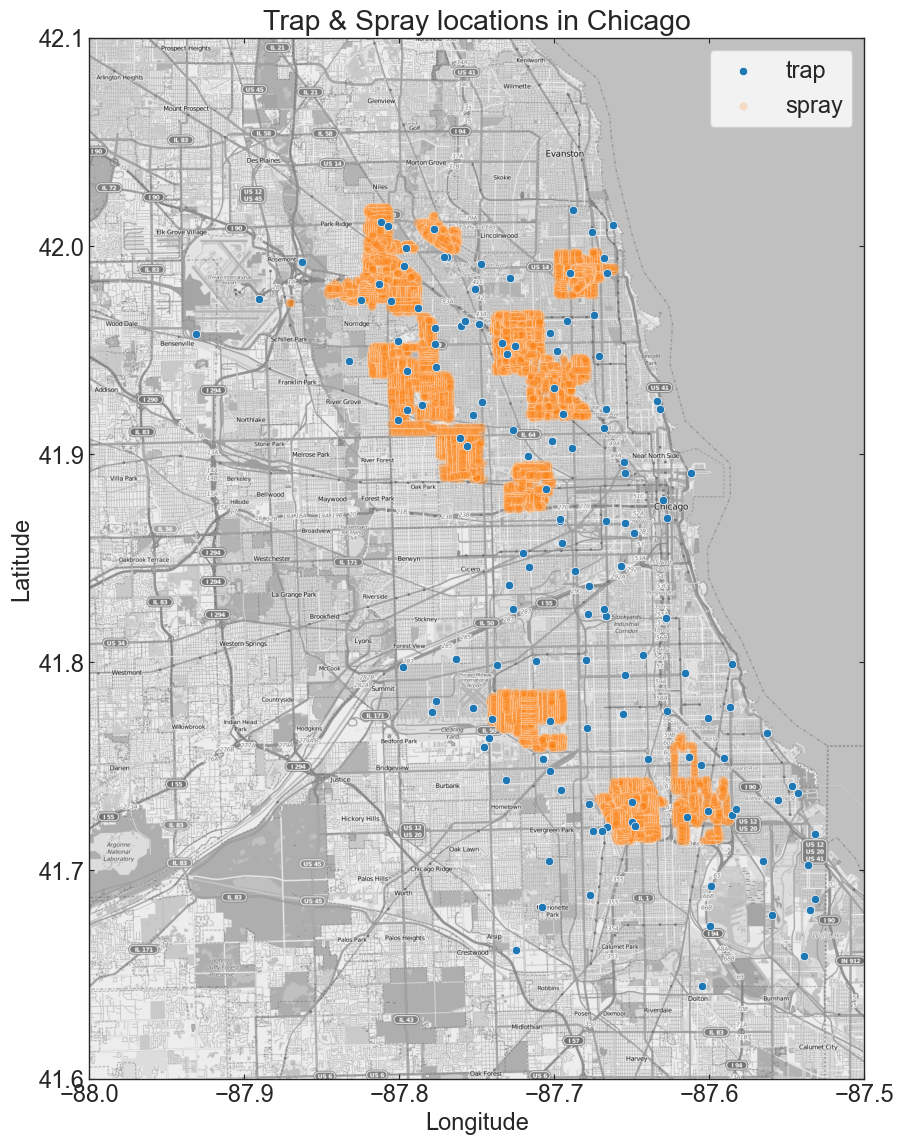

In [49]:
fig, ax = plt.subplots(figsize=(10,14))
ax.imshow(mapdata, cmap=plt.get_cmap('gray'), \
          extent=lon_lat_box, aspect=aspect)

trap_locations  = train[['Longitude', 'Latitude']].drop_duplicates().values
spray_locations = spray[['Longitude', 'Latitude']].drop_duplicates().values
sns.scatterplot(x=trap_locations[:,0], y=trap_locations[:,1], label='trap', ax=ax, zorder=1)
sns.scatterplot(x=spray_locations[:,0], y=spray_locations[:,1], label='spray', alpha=0.2, ax=ax, zorder=0)
ax.set_xlim(lon_lat_box[:2])
ax.set_ylim(lon_lat_box[2:])
ax.set(xlabel='Longitude', ylabel='Latitude', title='Trap & Spray locations in Chicago');